In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.in_out import PointCloudDataSet, load_point_clouds_from_filenames
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry, decoder_with_fc_only,\
encoder_with_convs_and_symmetry_and_fc

from tf_lab.in_out.basics import read_saved_epochs
from tf_lab.data_sets.articulated_human_poses import pc_loader
from tf_lab.point_clouds.convenience import reconstruct_pclouds
from tf_lab.data_sets.shape_net import snc_category_to_synth_id, load_all_point_clouds_under_folder

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_points = 2048
do_training = True
first_time_running = True
seed = 42
class_name = 'chair'
ae_loss = 'emd'
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
syn_id = snc_category_to_synth_id()[class_name]

In [5]:
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_points))
pclouds_path = osp.join(pclouds_path, syn_id)
pcloud_data = load_all_point_clouds_under_folder(pclouds_path)

In [12]:
# Load AE model
ae_id = '11' # 64 bottleneck for emd
ae_net_name = 'ae_farm_' + class_name + '_conv_arch_' + ae_id + '_' + str(n_pc_points)\
+ 'pts_' + ae_loss

ae_net_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))

if ae_conf.train_dir != ae_net_dir:
    ae_conf.train_dir = ae_net_dir
    ae_conf.save(osp.join(ae_conf.train_dir, 'configuration'))
    
reset_tf_graph()

ae = PointNetAutoEncoder(ae_net_name, ae_conf)
saved_epochs = read_saved_epochs(ae_conf.train_dir)
load_epoch = saved_epochs[-1]
ae.restore_model(ae_conf.train_dir, load_epoch, verbose=True)
print 'Bottleneck = ', ae.bottleneck_size
recon_pclouds, loss_val = reconstruct_pclouds(ae, pcloud_data.point_clouds, 100)
print 'Loss of reconstructed data ', loss_val

Model restored in epoch 1000.
Bottleneck =  64
Loss of reconstructed data  54.323539229


In [13]:
_, latent_codes, temp_names = ae.embedding_at_tensor(pcloud_data, ae_conf, tensor_name='bottleneck')
assert(np.alltrue(temp_names==pcloud_data.labels))
model_ids = np.array([i.split('_')[1] for i in pcloud_data.labels], dtype=object)

In [18]:
from general_tools.clustering.convenience import find_nearest_neighbors

In [25]:
nbrs, _ = find_nearest_neighbors(latent_codes, k=1)

In [52]:
mixed_train_data = PointCloudDataSet(pcloud_data.point_clouds, noise=pcloud_data.point_clouds[nbrs])

In [53]:
encoder_args = { 'n_filters': [64, 128, 256, 128],
                 'filter_sizes': [20, 10, 5, 5],
                 'strides': [1, 1, 2, 2],
                 'b_norm': False,
                }

decoder_args = {'layer_sizes': [1024, 2048, n_pc_points*3], 'b_norm': False}

In [78]:
experiment_name =  'manifold_traverser_0'
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/testing_ae_settings', experiment_name)
create_dir(train_dir)

conf = Conf(
            n_input = [n_pc_points, 3],
            loss = 'chamfer',
            training_epochs = 1000,
            batch_size = 50,
            denoising = True,
            learning_rate = 0.0005,
            train_dir = train_dir,              
            loss_display_step = 1,
            saver_step = 20,
            z_rotate = False,
            encoder = encoder_with_convs_and_symmetry,
            decoder = decoder_with_fc_only,
            encoder_args = encoder_args,
            decoder_args = decoder_args
           )    
conf.experiment_name = experiment_name
conf.save(osp.join(conf.train_dir, 'configuration'))

PicklingError: Can't pickle <type 'function'>: attribute lookup __builtin__.function failed

In [66]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

In [68]:
buf_size = 1 # flush each line
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)    
train_stats = ae.train(mixed_train_data, conf, log_file=fout)
fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.1455', 'loss=', '0.004043312')
INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/manifold_traverser_0/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0002', 'training time (minutes)=', '0.1402', 'loss=', '0.002110689')
('Epoch:', '0003', 'training time (minutes)=', '0.1376', 'loss=', '0.001768545')
('Epoch:', '0004', 'training time (minutes)=', '0.1330', 'loss=', '0.001546011')
('Epoch:', '0005', 'training time (minutes)=', '0.1362', 'loss=', '0.001399546')
('Epoch:', '0006', 'training time (minutes)=', '0.1414', 'loss=', '0.001291459')
('Epoch:', '0007', 'training time (minutes)=', '0.1402', 'loss=', '0.001205881')
('Epoch:', '0008', 'training time (minutes)=', '0.1386', 'loss=', '0.001150472')
('Epoch:', '0009', 'training time (minutes)=', '0.1345', 'loss=', '0.001093628')
('Epoch:', '0010', 'training time (minutes)=', '0.1326', 'loss=', '0.001054654')
('Epoch:'

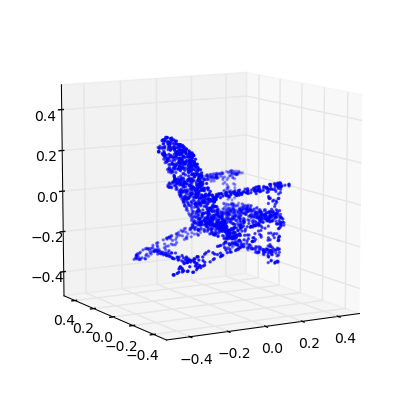

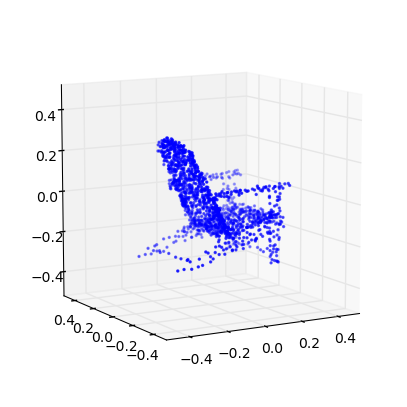

In [77]:
rid = np.random.randint(mixed_train_data.num_examples)
Point_Cloud(mixed_train_data.point_clouds[rid]).plot();
Point_Cloud(ae.reconstruct(np.expand_dims(mixed_train_data.point_clouds[rid], 0))[0][0]).plot();